#### Average Bubble Profile

In [1]:
import numpy as np
import math
import matplotlib
#matplotlib.rcParams.update({'font.size': 12})
from matplotlib import gridspec
import matplotlib.pyplot as plt
from collections import deque
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
import scipy.interpolate as intp
import statistics as stat
import random
from functools import partial
from operator import eq
from itertools import zip_longest, compress, count, islice, groupby, cycle
from labellines import labelLine, labelLines
import os
import scipy.ndimage
from scipy.ndimage import gaussian_filter, gaussian_filter1d

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


### Simulation Parameters 

In [2]:
nLat = 4096
nSims = 100
lSims = 0

nu = 2.*10**(-3)
lamb = 6; print('lamb = ', lamb)
m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff = ', m2eff)
lenLat = 2 * 50. / np.sqrt(2. * nu); print('lenLat = ', lenLat)
phi0 = 2. * np.pi / 7.; print('phi0 = ', phi0)

alpha = 8.
nCols = 1
phi_initial = np.pi
dt_phi_initial = 0.
mask = 4*phi_initial

############################################################
nyq = nLat//2+1
spec = nyq
hLat = nLat//2
dx = lenLat/nLat; print(dx)
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha
light_cone = dtout/dx

lamb =  6
m2eff =  0.28
lenLat =  1581.1388300841897
phi0 =  0.8975979010256552
0.3860202221885229


In [3]:
titles = [r'$\phi(x)$', r'$\partial_t \phi(x)$', r'$|\nabla \phi(x)|^2$', r'$V(\phi(x))$']
plots_file = '/home/dpirvu/big_plot_file/non_osc_thin_wall_average_bubble/'
pickle_location = '/home/dpirvu/pickle_location/non_osc_thin_wall_average_bubble/'
cutout_location = '/gpfs/dpirvu/non_osc_thin_wall_average_bubble/'
suffix = '_for_phi0{:.4f}'.format(phi0)+'_len{:.4f}'.format(lenLat)+'_lambda{:.4f}'.format(lamb)+'_x'+str(nLat)

def bubbles_file(min, max):
    return cutout_location+'bubbles_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def short_bubbles_file(min, max):
    return pickle_location+'short_bubbles_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def centred_bubbles_file(min, max):
    return pickle_location+'centred_bubbles_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def bubbles_at_rest_file(sim):
    return cutout_location+'restbubble_sim'+str(sim)+suffix+'.npy'
def average_bubble(min, max):
    return pickle_location+'average_bubble_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def new_bubble_data(min, max):
    return pickle_location+'bubbles_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def new_full_bubble_data(min, max):
    return cutout_location+'rest_bubbles_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def average_of_N_bubbles(Nbubbles):
    return pickle_location+'average_of_'+str(Nbubbles)+'_bubbles'+suffix+'.npy'

filter_size =  173.7779557760698


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:7: PeakPropertyWarning: some peaks have a width of 0
  import sys


Text(0, 0.5, '$\\phi$')

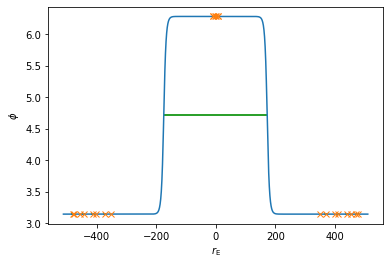

In [4]:
instanton_location = '/home/dpirvu/inst/instantons/dev/thin_wall_instanton_sim.dat'
a = np.genfromtxt(instanton_location)
coleman_profile = np.pi+a[:,0]
xoffset = nLat//8
temp = coleman_profile[len(coleman_profile)//2-xoffset:len(coleman_profile)//2+xoffset]
peaks, _ = scs.find_peaks(temp)
fwhm, height, left_ips, right_ips = scs.peak_widths(temp, peaks, rel_height=0.5)
filter_size = max(fwhm)/2.; print('filter_size = ', filter_size)
radius_Coleman_bubble = filter_size*dx

plt.plot(np.arange(len(temp))-xoffset, temp)
plt.plot(peaks-xoffset, temp[peaks], "x")
[plt.hlines(height[i], left_ips[i]-xoffset, right_ips[i]-xoffset, color="C2") for i in range(len(fwhm))]
plt.xlabel(r'$r_{\rm E}$'); plt.ylabel(r'$\phi$')

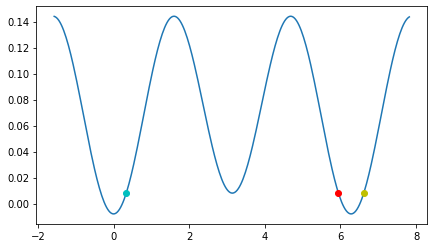

In [5]:
def V(phi):
    return ( -np.cos(phi) + 0.5 * lamb**2. * np.sin(phi)**2. ) * 4. * nu
def dV(phi):
    return ( np.sin(phi) + 0.5 * lamb**2. * np.sin(2.*phi) ) * 4. * nu

right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[np.pi, 2*np.pi], method='bounded')
left_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[0, np.pi], method='bounded')
right_left_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[2*np.pi, 3*np.pi], method='bounded')

def F(x):
    return V(x) - V(phi_initial)
phi_upper_bound = sco.fsolve(F, 5.5)[0]
phi_lower_bound = sco.fsolve(F, 0.5)[0]
phi_upper_lower_bound = sco.fsolve(F, 6.5)[0]

fig = plt.figure(figsize=(7, 4))
plt.plot([i for i in np.arange(-np.pi/2, 5*np.pi/2, np.pi/100)], [V(i) for i in np.arange(-np.pi/2, 5*np.pi/2, np.pi/100)])
plt.plot(phi_upper_bound, V(phi_upper_bound), 'ro')
plt.plot(phi_lower_bound, V(phi_lower_bound), 'co')
plt.plot(phi_upper_lower_bound, V(phi_upper_lower_bound), 'yo')

### VISUALISING SIMULATION DATA

In [6]:
all_data1, sims_to_keep1 = np.load(bubbles_file(0, 50))
all_data2, sims_to_keep2 = np.load(bubbles_file(50, nSims))
all_data = np.concatenate((all_data1, all_data2)).tolist()
sims_to_keep = np.concatenate((sims_to_keep1, sims_to_keep2)).tolist()
del all_data1, all_data2, sims_to_keep1, sims_to_keep2
normal = [phi_initial, np.mean([sim[1][0] for sim in all_data]), np.mean([sim[2][0] for sim in all_data]), V(phi_initial), np.mean([0.5*sim[1][0]**2 for sim in all_data])]

MemoryError: 

In [ ]:
#all_data, sims_to_keep = np.load(short_bubbles_file(0, 50))
#normal = [phi_initial, 0, 0, V(phi_initial), 0]

In [ ]:
def add_mask(field_slice, threshold):
    return field_slice * [0 if np.abs(i) > threshold else 1 for i in field_slice]

def find_slice_peaks(field_slice, peak_threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = signal.find_peaks(field_slice, height = peak_threshold)[0].tolist()
    if field_slice[-1] > peak_threshold and field_slice[0] > peak_threshold and field_slice[-1] != field_slice[0]:
        if field_slice[0] > field_slice[-1] and field_slice[0] > field_slice[1]:
            peak_coord.append(0)
        elif field_slice[0] < field_slice[-1] and field_slice[-1] > field_slice[-2]:
            peak_coord.append(len(field_slice)-1) # this minds potential boundary discontinuities
    peak_heights = [field_slice[coord] for coord in peak_coord]
    return peak_coord, field_slice.tolist().index(np.max(peak_heights))

def truncateNum(num, decimal_places):
    StrNum = str(num)
    p = StrNum.find(".") + 1 + decimal_places
    return float(StrNum[0:p])

def time_at_fraction(bubble, frac, limit):
    T, N = len(bubble), len(bubble[0])
    right_phi_x = [np.sum([1 for x in slice if mask > x >= limit]) for slice in bubble]
    time_list = [t if (right_phi_x[t] <= N*frac) else 0 for t in range(T)]
    return next((t for t in time_list[::-1] if t != 0), 0)

def time_at_size(bubble, size, limit):
    T, N = len(bubble), len(bubble[0])
    right_phi_x = [np.sum([1 for x in slice if mask > x >= limit]) for slice in bubble]
    time_list = [t if (right_phi_x[t] <= size) else 0 for t in range(T)]
    return next((t for t in time_list[::-1] if t != 0), T-1)

def center_bubble(bubble):
    bubble0 = bubble[0]
    #truncate bubble where it expands relativistically
    limit = phi_upper_bound
    tdecap = time_at_fraction(bubble0, 0.7, right_phi_at_V_max.x)
    print('tdecap: ', tdecap)
    T, N = len(bubble0), len(bubble0[0])

    #rotate bubble such that the relativistic bit is perfectly centered
    fld = gaussian_filter1d(bubble0[tdecap], sigma=1)
    kafslj = next(iter([x for x in range(N-1) if fld[x] > limit]))

    if kafslj < 30:
        fld = gaussian_filter1d(bubble0[tdecap], sigma=1)
        vals = [x if (fld[x] > limit and fld[x+1] > limit) else 0 for x in range(N-1)]
        bubbles = [list(g) for k, g in groupby(vals, lambda x: x != 0) if k]
        maxi, imax, keep = 0, 0, 0
        for i in range(len(bubbles)-1):
            maxi = bubbles[i+1][0]-bubbles[i][-1]
            if maxi > imax:
                imax = maxi
                keep = i
        first_zero = int(np.mean([bubbles[keep][0], bubbles[keep][-1]]))
        fld = np.roll(bubble0[tdecap], -first_zero)
        target_peak = int(round(np.mean([x for x in range(N-1) if (fld[x] > limit and fld[x+1] > limit)]))) # center of bubble
    #    print(first_zero, target_peak)    
        angle = int(N//2) - (target_peak + first_zero) # rotation angle needed
        bubble = np.asarray([[np.roll(bubble[col][t], angle) for t in range(tdecap)] for col in range(len(bubble))])
    else:
        bubble = np.asarray([bubble[col][:tdecap] for col in range(len(bubble))])

    # check which sides the COM travels
    bubble0 = bubble[0]
    tcheck = time_at_fraction(bubble0, 0.02, 2*phi_initial)
#    print(tcheck)
    fld = [gaussian_filter1d(slice, sigma=1) for slice in bubble0[tcheck-100:tcheck:2]]
    tv = [np.nanmean([x for x in range(N) if fld[t][x] > 2*phi_initial]) for t in range(len(fld))]
    decr = np.sum([1 for i, j in zip(tv, tv[1::]) if i > j])
    incr = np.sum([1 for i, j in zip(tv, tv[1::]) if i < j])
#    print(incr, decr)
    return bubble, decr - incr

def multiply_bubble(bubble, dir, fold):
    bubble0 = bubble[0]
    T, N = len(bubble0), len(bubble0[0])
    bubble = [np.tile(bubble[col], fold) for col in range(len(bubble))] # multiplies bubbles so tail is kept without pbc
    TT, NN = len(bubble[0]), len(bubble[0][0])
    for t in range(TT):
        a, b = int((TT-t)*light_cone) + N - 200, int((TT-t)*light_cone/2) - N//4
        x1, x2 = np.arange(a, NN), np.arange(b)
        if dir < 0:
            x1, x2 = x1 - a, x2 - (b-NN)
        for x in np.append(x1, x2):
            if 0 <= x < NN:
                bubble[0][t][x] = phi_initial
    return np.asarray(bubble)

In [ ]:
for sim in range(len(all_data))[:2:]:
    print(sim)
    col = 0
    simulation = all_data[sim]
    centered, dir = center_bubble(simulation)
    tdecap = time_at_fraction(centered[0], 0.1, right_phi_at_V_max.x)
    xlist = [x for x in range(len(centered[0][tdecap])) if centered[0][tdecap][x] > 2*np.pi]
    print(tdecap, stat.stdev(xlist))
    if stat.stdev(xlist) < 150:
        mult = multiply_bubble(centered, dir, 2)
        fig, ax = plt.subplots(1, 3, figsize = (12, 3))
        im0 = ax[0].imshow(simulation[col], aspect='auto', interpolation='none', origin='lower')
        im1 = ax[1].imshow(centered[col], aspect='auto', interpolation='none', origin='lower')
        im2 = ax[2].imshow(mult[col], aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax[0]); clb = plt.colorbar(im1, ax = ax[1]); clb = plt.colorbar(im2, ax = ax[2]); plt.show()

In [ ]:
def rapidity(vel):
    return np.arctanh(vel)
def gamma(v):
    return ( 1. - v**2. )**(-0.5)

def get_bubble_radius(bubble_slice, filter):
    bubble_slice = gaussian_filter1d(bubble_slice, sigma=filter)
    results_half = signal.peak_widths(bubble_slice, signal.find_peaks(bubble_slice)[0], rel_height=0.5)
    return max(results_half[0])/2.

def tanh_pos(x, r0L, r0R, dr, vL, vR):
    wL, wR = dr/gamma(vL), dr/gamma(vR)
    return ( np.tanh( (x - r0L)/wL ) + np.tanh( (r0R - x)/wR ) ) * np.pi/2 + np.pi
def tanh_neg(x, r0L, r0R, dr, vL, vR):
    wL, wR = dr/gamma(vL), dr/gamma(vR)
    return - ( np.tanh( (x - r0L)/wL ) + np.tanh( (r0R - x)/wR ) ) * np.pi/2 + np.pi

def tanh_fit(bubble_slice, axis, prior):
#    plt.plot(axis, bubble_slice, 'ro', axis, [tanh(r, *best_tanh) for r in axis], 'g'); plt.show()
    bounds = ((axis[0], 0, 0, 0, 0), (0, axis[-1], axis[-1], 1, 1))
    if prior is not None:
        if np.mean(bubble_slice) > phi_initial:
            return sco.curve_fit(tanh_pos, axis, bubble_slice, p0=prior, bounds=bounds)[0]
        else:
            return sco.curve_fit(tanh_neg, axis, bubble_slice, p0=prior, bounds=bounds)[0]            
    else:
        if np.mean(bubble_slice) > phi_initial:
            return sco.curve_fit(tanh_pos, axis, bubble_slice, bounds=bounds)[0]
        else:
            return sco.curve_fit(tanh_neg, axis, bubble_slice, bounds=bounds)[0]

def hyperbola1(t, a, b, c):
    return np.sqrt(c + (t - b)**2) + a
def hyperbola2(t, d, e, f):
    return - np.sqrt(f + (t - e)**2) + d

def hypfit_test(tt, rr, qq): # no parameters in common between left and right wall for hyperbolic curve fit
    try:
        if rr[0] <= rr[-1]:
            fit1, pcov1 = sco.curve_fit(hyperbola1, tt, rr, p0 = (min(rr), tt[rr.tolist().index(min(rr))], 1e4))
            fit2, pcov2 = sco.curve_fit(hyperbola2, tt, qq, p0 = (max(qq), tt[qq.tolist().index(max(qq))], 1e4))
        else:
            fit1, pcov1 = sco.curve_fit(hyperbola2, tt, rr, p0 = (max(rr), tt[rr.tolist().index(max(rr))], 1e4))
            fit2, pcov2 = sco.curve_fit(hyperbola1, tt, qq, p0 = (min(qq), tt[qq.tolist().index(min(qq))], 1e4))
        return True
    except (RuntimeError, TypeError):
        return False
    
def hypfit(tt, rr, qq): # no parameters in common between left and right wall for hyperbolic curve fit
    if rr[0] <= rr[-1]:
        fit1, pcov1 = sco.curve_fit(hyperbola1, tt, rr, p0 = (min(rr), tt[rr.tolist().index(min(rr))], 1e4))
        fit2, pcov2 = sco.curve_fit(hyperbola2, tt, qq, p0 = (max(qq), tt[qq.tolist().index(max(qq))], 1e4))
        traj1, traj2 = hyperbola1(tt, *fit1), hyperbola2(tt, *fit2)
    else:
        fit1, pcov1 = sco.curve_fit(hyperbola2, tt, rr, p0 = (max(rr), tt[rr.tolist().index(max(rr))], 1e4))
        fit2, pcov2 = sco.curve_fit(hyperbola1, tt, qq, p0 = (min(qq), tt[qq.tolist().index(min(qq))], 1e4))
        traj1, traj2 = hyperbola2(tt, *fit1), hyperbola1(tt, *fit2)
#    print('hyperbolic trajectories fit: ', fit1, fit2)
#    plt.plot(rr, tt, 'g-', qq, tt, 'r-', traj1, tt, 'y:', traj2, tt, 'b:') # plot the equation using the fitted parameters
    return tt, traj1, traj2

def get_velocities(tt, rrwallfit, llwallfit):
    #uu = wall travelling along with the com; vv = wall travelling against the com; aa = centre of mass velocity; bb = instantaneous velocity of wall
    uu = intp.splev(tt, intp.splrep(tt, rrwallfit), der=1)
    vv = intp.splev(tt, intp.splrep(tt, llwallfit), der=1)
    for i in range(len(uu)):
        if np.abs(uu[i]) > 1:
            uu[i] = np.sign(uu[i])*(1-np.abs(np.abs(uu[i])-1))
        if np.abs(vv[i]) > 1:
            vv[i] = np.sign(vv[i])*(1-np.abs(np.abs(vv[i])-1))
#    print(uu)
#    print(vv)
    for i in range(len(uu)):
        if str(uu[i]) == 'nan' :
            uu[i] = - np.sign(vv[-1])*0.999
        if str(vv[i]) == 'nan' :
            vv[i] = - np.sign(uu[-1])*0.999
#    print(uu)
#    print(vv)
#    if all(np.abs(i) > 1 for i in uu):
#        uu = np.asarray([np.sign(i)*(1-np.abs(np.abs(i)-1)) for i in uu])
#    if all(np.abs(i) > 1 for i in vv):
#        vv = np.asarray([np.sign(i)*(1-np.abs(np.abs(i)-1)) for i in vv])

    aa = ( 1 + uu*vv - np.sqrt( (-1 + uu**2)*(-1 + vv**2))) / ( uu + vv)
    bb = (-1 + uu*vv + np.sqrt( (-1 + uu**2)*(-1 + vv**2))) / (-uu + vv)
    return uu, vv, aa, bb#, ch1, ch2

def velocity(bubble, bool):
    T, N = len(bubble), len(bubble[0])
    limit = phi_upper_bound - 0.5 #phi_upper_bound# - 0.5*np.abs(phi_upper_bound-np.floor(phi_upper_bound))
    prior = None
    data_list = []
    err = 0

    # find where fit can begin
    window = int(N//10)
    if window > 100: window = 100

    tf = T-1
    endSlice = [i for i in range(N) if np.cos(bubble[tf][i]) > np.cos(limit)]
    if len(endSlice) == 0:
        return 'next'
    while endSlice[0] - window < 0 or endSlice[-1] + window >= N:
        tf -= 2
        endSlice = [i for i in range(N) if np.cos(bubble[tf][i]) > np.cos(limit)]
        if len(endSlice) == 0:
            return 'next'

    for t in range(tf, 0, -1):
        if len(data_list) == 0:
            peaks = endSlice
            target = int(np.round(np.nanmean(peaks)))
            coord_list = np.arange(peaks[0] - window, peaks[-1] + window)
        else:
            xrange = np.arange(data_list[-1][0]-window, data_list[-1][0]+window+1)
            if all(0 <= i < N for i in xrange) and any(np.cos(bubble[t][i]) > np.cos(limit) for i in xrange):
                peaks = [i for i in xrange if np.cos(bubble[t][i]) > np.cos(limit)]
            else:
                break
            target = int(np.round(np.nanmean(peaks)))
            coord_list = np.arange(target - int(np.round(np.abs(data_list[-1][1]))) - window, target + int(np.round(np.abs(data_list[-1][2]))) + window)

        coords = np.asarray([(bubble[t][i%N], int(i-target)) for i in coord_list])
        if err < 5:
            try:
                r0L, r0R, dr, vL, vR = tanh_fit(coords[:,0], coords[:,1], prior)
                prior = r0L, r0R, dr, vL, vR
                data_list.append([target, r0L, r0R, int(t)])
            except (RuntimeError, ValueError, TypeError):
                prior = None
                data_list.append([target, r0L + np.sign(data_list[-1][1]-data_list[0][1])*light_cone*(T/N), r0R + np.sign(data_list[-1][2]-data_list[0][2])*light_cone*(T/N), int(t)])
                err += 1
        else:
            break
    data_list = np.asarray(data_list[::-1])
    targets, r0Ls, r0Rs, time_list = data_list[:,0], data_list[:,1], data_list[:,2], data_list[:,-1]
#    print('tmin, tmax', time_list[0], time_list[-1])

    # get direction of bubble
    radius_diff = np.mean([np.abs(data_list[i,1]) - np.abs(data_list[i,2]) for i in range(len(data_list)//4)])
    if radius_diff > 0:  # if average difference in radius is positive then left radius is on average higher than right radius i.e. bubble travels to the right
        rr, ll = targets + r0Rs, targets + r0Ls
    else:
        rr, ll = targets + r0Ls, targets + r0Rs

    if bool:
        fig, ax0 = plt.subplots(1, 1, figsize = (5, 4))
        ax0.plot(rr, time_list, 'b', ll, time_list, 'y', linewidth='3')
        ax0.set_xlabel('x'); ax0.set_ylabel('t')

    # get velocities from derivative of best fit to wall trajectory
    trunc = 0
    # save copies
    time_list_copy, rr_copy, ll_copy = time_list, rr, ll
    # as lons as it needs..
    while(True):
        # try to fit walls
        if hypfit_test(time_list_copy, rr_copy, ll_copy):
            time_list, rrwallfit, llwallfit = hypfit(time_list_copy, rr_copy, ll_copy)
            uu,vv,aa,bb = get_velocities(time_list, rrwallfit, llwallfit)
            break
        # if fit fails, shorten walls
        else:
            trunc += 25
            if len(time_list_copy) > 100 + trunc*2:
                time_list_copy, rr_copy, ll_copy = time_list_copy[trunc:-trunc:], rr_copy[trunc:-trunc:], ll_copy[trunc:-trunc:]
            if trunc > 200 or len(time_list_copy) < 100:
                return 'next'
            continue
#    if hypfit_test(time_list, rr, ll):
#        time_list, rrwallfit, llwallfit = hypfit(time_list, rr, ll)
#    else:
#        return 'next'
#    uu,vv,aa,bb = get_velocities(time_list, rrwallfit, llwallfit)

#    if bool:
#        fig, [ax0, ax1] = plt.subplots(1, 2, figsize = (15, 4))
#        ax0.plot(rr[-len(time_list):], time_list, 'b', ll[-len(time_list):], time_list, 'y', rrwallfit, time_list, 'r:', llwallfit, time_list, 'r:', linewidth='3')
#        ax0.set_xlabel('x'); ax0.set_ylabel('t')
#        ax1.plot(time_list, uu, 'b:', time_list, vv, 'y:')
#        ax1.plot(time_list, aa, 'r', label=r'v COM')
#        ax1.plot(time_list, bb, 'g', label=r'v walls')
#        ax1.axhline(0, color='darkgray', ls=':')
#        ax1.set_xlabel('t'); ax1.set_ylabel('v(t)'); ax1.legend(); plt.show()
#        plt.savefig(plots_file+'velocity_profile'+str(random.randrange(100))+suffix+'.png');

    list = np.abs(aa - bb)
    if any(str(i) != 'nan' for i in list):
        return -aa[list.tolist().index(np.nanmin(list))]
    else:
        return 'next'

In [ ]:
def fold(beta):
    if np.abs(beta) > 0.8:
        return 3
    else:
        return 2

def add_velocities(v1,v2):
    return (v1 + v2) / (1. + v1*v2)

def cut_out_bubble(bubble):
    bubble0 = bubble[0]
    limit = np.floor(phi_upper_bound)
    T, N = len(bubble0), len(bubble0[0])
    ext = int(N//8)
    if ext < 100: ext = 200
    xmin = next((i for i in range(N) if bubble0[-1][i] > limit), 0) - ext
    xmax = next((i for i in range(N)[::-1] if bubble0[-1][i] > limit), N-1) + ext
    if xmin < 0: xmin = 0
    if xmax >= N: xmax = N-1
    t, tmin = 0, 0
    while not any(bubble0[t][i] > limit for i in range(xmin, xmax+1)):
        tmin = t
        t += 1
    return [[[bubble[col][t][x] for x in range(xmin, xmax+1)] for t in range(tmin, T)] for col in range(len(bubble))]

def center_bubble_again(bubble, kind):
    bubble0 = bubble[0]
    T, N = len(bubble0), len(bubble0[0])
    ext = int(N//8)
    if ext < 100: ext = 200
    if kind < 0:
        x1 = 0
        peaks1 = [phi_initial, phi_initial]
        while np.cos(np.nanmean(peaks1)) < np.cos(3.17) and x1 < N-1:
#        while len([i for i,j in zip(peaks1, peaks1[1:]) if (i > right_phi_at_V_max.x and j > right_phi_at_V_max.x)]) > 10 and x1 < N-1:
            slice = [bubble0[i][x1] for i in range(T)]
            peaks1 = [i for i in slice if i < mask]
            peaks2 = [i for i in range(T) if slice[i] < mask]
            x1 += 1
        if len(peaks2) > 0:
            tmax = peaks2[-1]
        else:
            return 'next'
#        print('tmax, x1', tmax, x1)
        xmin = x1 - ext
        if xmin < 0: xmin = 0
        xmax = next((i for i in range(N-1, xmin, -1) if (mask > bubble0[tmax][i] > phi_initial)), N-1)
    else:
        x1 = N-1
        peaks1 = [phi_initial, phi_initial]
        while np.cos(np.nanmean(peaks1)) < np.cos(3.17) and x1 > 0:
#        while len([i for i,j in zip(peaks1, peaks1[1:]) if (i > right_phi_at_V_max.x and j > right_phi_at_V_max.x)]) > 10 and x1 > 0:
            slice = [bubble0[i][x1] for i in range(T)]
            peaks1 = [i for i in slice if i < mask]
            peaks2 = [i for i in range(T) if slice[i] < mask]
            x1 -= 1
        if len(peaks2) > 0:    
            tmax = peaks2[-1]
        else:
            return 'next'
#        print('tmax, x1', tmax, x1)
        xmax = x1 + ext
        if xmax > N-1: xmax = N-1
        xmin = next((i for i in range(xmax) if (mask > bubble0[tmax][i] > phi_initial)), 0)

    t, tmin = 0, 0
    while not any([(mask > bubble0[t][i] > phi_initial) for i in range(xmin, xmax+1)]):
        tmin = t
        t += 1
    return [[[bubble[col][t][x] if bubble[col][t][x] != mask else normal[col] for x in range(xmin, xmax+1)] for t in range(tmin, tmax+1)] for col in range(len(bubble))]

def boost(vCOM, ga, x, t):
    return ga * (x - vCOM*t)

def interpolate_bubble(bubble, res):
    NT, N = len(bubble), len(bubble[0])
    bubble = np.asarray(bubble)
    t, x = np.arange(NT), np.arange(N)
    tt, xx = np.meshgrid(t, x)
    f = intp.interp2d(t, x, bubble[tt, xx], kind = 'quintic')
    T, X = np.arange(0, NT, 1/res), np.arange(0, N, 1/res)
    return f(T, X).T

def boost_bubble(bubble, vCOM, res):
    bubble0 = bubble[0]
    T, N = len(bubble0), len(bubble0[0])
    limit = np.ceil(phi_upper_bound)
    ga = gamma(vCOM)

    t0 = int(time_at_size(bubble0, 100, limit)) # arbitrary choice of bubble centre
    x0 = np.mean([i for i in range(N) if mask > bubble0[t0][i] > limit])
    print('boost centre t0, x0: ', t0, x0)
    T0, X0 = boost(vCOM, ga, t0, x0), boost(vCOM, ga, x0, t0)
    deltaT, deltaX = np.abs(T0-t0), np.abs(X0-x0)

    bubble = [interpolate_bubble(bubble[col], res) for col in range(len(bubble))]
    new_bubble = [[[mask for x in range(N)] for t in range(T)] for col in range(len(bubble))]
    for t in range(T):
        for x in range(N):
            tt = int((boost(vCOM, ga, t, x) + np.sign(T//2-t0) * deltaT)*res)
            xx = int((boost(vCOM, ga, x, t) + np.sign(N//2-x0) * deltaX)*res)
            if (T*res > tt >= 0 and N*res > xx >= 0):
                for col in range(len(bubble)):
                    new_bubble[col][t][x] = bubble[col][tt][xx]
    return new_bubble, x0 - N//2

In [ ]:
def the_whole_shebang(resolution, saveF):
    for sim in range(len(all_data))[::]:
        exists = os.path.exists(bubbles_at_rest_file(sim))
        if not exists:

            print(sim)
            bubble, dir = center_bubble(all_data[sim])
            tdecap = time_at_fraction(bubble[0], 0.1, right_phi_at_V_max.x)
            xlist = [x for x in range(len(bubble[0][tdecap])) if bubble[0][tdecap][x] > 2*np.pi]
            if stat.stdev(xlist) < 150:

                beta = velocity(bubble[0], True)
                if beta == 'next':
                    print('sim '+str(sim)+' skipped')
                    continue
                elif np.abs(beta) > 0.9:
                    beta = np.sign(beta)*0.9
                bubble = multiply_bubble(bubble, dir, fold(beta))

                fig = plt.figure(figsize=(5,5))
                plt.imshow(bubble[0], aspect='auto', interpolation='none', origin='lower')
                plt.show()

                vtotal, bool1, bool2 = 0, True, False
                while np.abs(beta) > 0.1:
                    bool2 = True
                    bubble, dir = boost_bubble(bubble, beta, resolution)
                    bubble = center_bubble_again(bubble, dir)
                    if bubble == 'next':
                        print('sim '+str(sim)+' interrupted')
                        bool1 = False
                        break

                    fig = plt.figure(figsize=(5,5))
                    plt.imshow(bubble[0], aspect='auto', interpolation='none', origin='lower')
                    plt.show()

                    prebeta = beta
                    vtotal = add_velocities(vtotal, beta)
                    print('step done ', beta)

                    min_bubble = cut_out_bubble(bubble)
                    fig = plt.figure(figsize=(5,5))
                    plt.imshow(bubble[0], aspect='auto', interpolation='none', origin='lower')
                    plt.show()

                    beta = velocity(min_bubble[0], True)
                    if beta == 'next':
                        print('sim '+str(sim)+' interrupted')
                        if np.abs(prebeta) >= 0.8:
                            bool1 = False
                        break
                    elif np.abs(beta) > 0.9:
                        beta = np.sign(beta)*0.9

                if not bool2:
                    if np.abs(beta) > 0:
                        min_bubble = cut_out_bubble(bubble)
                        vtotal = beta
                        bool2 = True

                if bool1 and bool2:
                    print('sim', sim, 'total vel ', vtotal)
                    if saveF:
                        np.save(bubbles_at_rest_file(sims_to_keep[sim]), [min_bubble, vtotal])
    return

In [ ]:
#the_whole_shebang(3, True)
#the_whole_shebang(1, False)

### Average bubble

In [ ]:
 def cut_out_coordinates(bubble0):
    T, N = len(bubble0), len(bubble0[0])
    limit = phi_upper_bound - np.abs(phi_upper_bound-np.floor(phi_upper_bound))*0.5
    size = 100 # do not change

    tmin = T-1
    for t in range(T):
        slice = gaussian_filter1d(bubble0[t], sigma=1)
        right_phi = [x for x in range(N-1) if (slice[x] >= limit and slice[x+1] >= limit)]
        if len(right_phi) >= size:
            tmin = t
            break
    if tmin == T-1:
        return None
    xcen = int(np.round(np.nanmean(right_phi)))
    xcen_list = [np.round(np.nanmean([x for x in range(N) if bubble0[t][x] >= limit])) for t in range(tmin-50,tmin,2)]
    if stat.stdev(xcen_list) > 100:
        return None

#    fig = plt.figure(figsize=(4,4))
#    plt.plot(xcen, tmin, 'ro')
#    plt.imshow(bubble, aspect='auto', interpolation='none', origin='lower')
#    plt.show()
    ex1, ex2, ex3, ex4 = np.arange(tmin)[::-1], np.arange(tmin, T), np.arange(xcen)[::-1], np.arange(xcen, N)

    if len(ex1) > 2000: ex1 = ex1[:2000]
    if len(ex2) > 500: ex2 = ex2[:500]
    if len(ex3) > 500: ex3 = ex3[:500]
    if len(ex4) > 500: ex4 = ex4[:500]    
    return ex1, ex2, ex3, ex4

def stack_bubbles(bubble_data):
    extent_list, bad_bubbles = [], []

    for sim in range(len(bubble_data)):
        coords = cut_out_coordinates(bubble_data[sim][0])
        if coords is not None:
            extent_list.append(coords)
        else:
            bad_bubbles.append(sim)

    extent_list = np.asarray(extent_list)
    print('bad bubbles', bad_bubbles)

    bubble_data = [bubble_data[i] for i in range(len(bubble_data)) if i not in bad_bubbles]
    for sim in range(len(bubble_data)):
        bubble_data[sim].append([0.5*np.asarray(i)**2 for i in bubble_data[sim][1]])
    nCols = len(bubble_data[0])

    uper_right_bubble_list = [[[[bubble_data[sim][col][t][x] for t in extent_list[:,0][sim]] for x in extent_list[:,2][sim]] for sim in range(len(bubble_data))] for col in range(nCols)]
    upper_left_bubble_list = [[[[bubble_data[sim][col][t][x] for t in extent_list[:,0][sim]] for x in extent_list[:,3][sim]] for sim in range(len(bubble_data))] for col in range(nCols)]
    lower_right_bubble_list = [[[[bubble_data[sim][col][t][x] for t in extent_list[:,1][sim]] for x in extent_list[:,2][sim]] for sim in range(len(bubble_data))] for col in range(nCols)]
    lower_left_bubble_list = [[[[bubble_data[sim][col][t][x] for t in extent_list[:,1][sim]] for x in extent_list[:,3][sim]] for sim in range(len(bubble_data))] for col in range(nCols)]
    return [uper_right_bubble_list, upper_left_bubble_list, lower_right_bubble_list, lower_left_bubble_list], bad_bubbles

def average_bubble_func(stacked_bubble_data):
    uper_right_bubble_list, upper_left_bubble_list, lower_right_bubble_list, lower_left_bubble_list = stacked_bubble_data
    nCols = len(uper_right_bubble_list)
    print(nCols)

    av_mat, av_err_mat = [], []
    for col in range(nCols):
        average_matrix, average_error_matrix = [[],[],[],[]], [[],[],[],[]]
        coord_lists = [uper_right_bubble_list[col], upper_left_bubble_list[col], lower_right_bubble_list[col], lower_left_bubble_list[col]]

        for i in range(4): #for each quadrant
            max_lines, max_cols = 0, 0
            for simulation in coord_lists[i]:
                if len(simulation) > max_lines:
                    max_lines = len(simulation)
                if len(simulation[0]) > max_cols:
                    max_cols = len(simulation[0])

            for line in range(max_lines):
                average_matrix[i].append([normal[col] for nn in range(max_cols)])
                average_error_matrix[i].append([0. for nn in range(max_cols)])

            for num_line in range(max_lines):
                for num_col in range(max_cols):
                    meas = []
                    for simulation in coord_lists[i]:
                        if len(simulation) > num_line and len(simulation[0]) > num_col:
                            meas.append(simulation[num_line][num_col])

                    average_matrix[i][num_line][num_col] = np.mean(meas)
                    if len(meas) >= 2:
                        average_error_matrix[i][num_line][num_col] = stat.stdev(meas)/len(meas)
        av_mat.append(average_matrix)
        av_err_mat.append(average_error_matrix)

    whole_bubbles = []
    for av_bub in [av_mat, av_err_mat]:
        whole_bubbles.append([])
        for col in range(nCols):
            top = np.concatenate((np.flip(np.asarray(np.flip(av_bub[col][0],1)).transpose(),1), np.flip(np.asarray(av_bub[col][1]).transpose(),0)), axis=1)
            bottom = np.concatenate((np.flip(np.asarray(av_bub[col][2]).transpose(),1), np.flip(np.asarray(np.flip(av_bub[col][3],0)).transpose(),1)), axis=1)
            whole_bubbles[-1].append(np.concatenate((top, bottom), axis=0))
    return np.asarray(whole_bubbles)

def truncated_full_bubbles_stacked(stacked_bubble_data):
    uper_right_bubble_list, upper_left_bubble_list, lower_right_bubble_list, lower_left_bubble_list = stacked_bubble_data
    nCols = len(uper_right_bubble_list)

    whole_bubbles = []
    for sim in range(len(uper_right_bubble_list[0])):
        whole_bubbles.append([])
        for col in range(nCols):
            bub0 = uper_right_bubble_list[col][sim]
            bub1 = upper_left_bubble_list[col][sim]
            bub2 = lower_right_bubble_list[col][sim]
            bub3 = lower_left_bubble_list[col][sim]

            top = np.concatenate((np.flip(np.asarray(np.flip(bub0,1)).transpose(),1), np.flip(np.asarray(bub1).transpose(),0)), axis=1)
            bottom = np.concatenate((np.flip(np.asarray(bub2).transpose(),1), np.flip(np.asarray(np.flip(bub3,0)).transpose(),1)), axis=1)
            whole_bubbles[-1].append(np.concatenate((top, bottom), axis=0))
    return whole_bubbles

def truncated_bubbles_stacked(stacked_bubble_data):
    uper_right_bubble_list, upper_left_bubble_list, lower_right_bubble_list, lower_left_bubble_list = stacked_bubble_data
    nCols = len(uper_right_bubble_list)

    whole_bubbles = []
    for sim in range(len(uper_right_bubble_list[0])):
        bub0 = uper_right_bubble_list[0][sim]
        bub1 = upper_left_bubble_list[0][sim]
        bub2 = lower_right_bubble_list[0][sim]
        bub3 = lower_left_bubble_list[0][sim]

        top = np.concatenate((np.flip(np.asarray(np.flip(bub0,1)).transpose(),1), np.flip(np.asarray(bub1).transpose(),0)), axis=1)
        bottom = np.concatenate((np.flip(np.asarray(bub2).transpose(),1), np.flip(np.asarray(np.flip(bub3,0)).transpose(),1)), axis=1)
        whole_bubbles.append(np.concatenate((top, bottom), axis=0))
    return whole_bubbles

In [ ]:
bubble_list = np.asarray([np.load(bubbles_at_rest_file(sim)) for sim in range(nSims) if os.path.exists(bubbles_at_rest_file(sim))])
bubble_list_save, bubble_velocities = bubble_list[:,0], bubble_list[:,1]

In [ ]:
#either compute average
stacked_bubble_parts, bad_bubbles = stack_bubbles(bubble_list_save)
ab, error_ab = average_bubble_func(stacked_bubble_parts)
np.save(average_bubble(lSims, nSims), [ab, error_ab])

newBubbleData = truncated_bubbles_stacked(stacked_bubble_parts)
newfullBubbleData = truncated_full_bubbles_stacked(stacked_bubble_parts)
np.save(new_bubble_data(lSims, nSims), newBubbleData)
np.save(new_full_bubble_data(lSims, nSims), newfullBubbleData)

#or load it
#ab, error_ab = np.load(average_bubble(lSims, nSims))
#newBubbleData = np.load(new_bubble_data(lSims, nSims)).tolist()
#newfullBubbleData = np.load(new_full_bubble_data(lSims, nSims)).tolist()

#separate columns
bubble, mom_bubble, ge_bubble, pe_bubble, ke_bubble = ab
error_bubble, error_mom_bubble, error_ge_bubble, error_pe_bubble, error_ke_bubble = error_ab

In [ ]:
#plot average bubble, mom_bubble, ge_bubble, pe_bubble, ke_bubble
fig, ax = plt.subplots(1, len(ab), figsize=(25, 5))
for col in range(len(ab)):
    im = ax[col].imshow(ab[col], aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im, ax = ax[col])
plt.savefig(plots_file+'average_bubble'+suffix+'.png')

#plot distribution of boosts
bubble_velocities = [bubble_velocities[i] for i in range(len(bubble_velocities)) if i not in bad_bubbles]
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].hist(bubble_velocities, bins=len(bubble_velocities))
ax[1].hist([gamma(i) for i in bubble_velocities], bins=len(bubble_velocities))
ax[2].hist([rapidity(i) for i in bubble_velocities], bins=len(bubble_velocities))

[ax[i].set_ylabel('Count') for i in range(len(ax))]
ax[0].set_xlabel(r'$v$'); ax[1].set_xlabel(r'$\gamma$'); ax[2].set_xlabel(r'$w$');
plt.savefig(plots_file+'boost_distrib'+suffix+'.png');

In [ ]:
#average x bubbles at a time; save
Nbubs = len(newfullBubbleData)
step = 2
for ii in range(0, Nbubs, step):
    boolBreak = False
    qq = len(newfullBubbleData)
    print(qq)
    stacked_bubble_parts, _ = stack_bubbles(np.asarray(newfullBubbleData)[:,:-1].tolist())
    ab, error_ab = average_bubble_func(stacked_bubble_parts)
    np.save(average_of_N_bubbles(qq), [ab, error_ab, qq])
    for jj in range(step):
        if len(newfullBubbleData) > 2:
            del newfullBubbleData[0]
        else:
            boolBreak = True
            break
    if boolBreak:
        break